In [2]:
import os
import multiprocessing as mp
from functools import reduce, partial

import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import copy
import gc

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn import preprocessing

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional

from preproc import import_csv

In [72]:
def dist_plot(series: pd.core.series.Series, dropna: bool = True) -> NoReturn:
    """
        Given a pandas Series, generate a descriptive visualisation 
        with a boxplot and a histogram with a kde.
        By default, this function drops `nan` values. If you desire to
        handle them differently, you should do so beforehand and/or
        specify dropna=False.
    """
    
    if dropna:
        series = series.dropna()
    
    quarts = scipy.stats.mstats.mquantiles(series, [0.001, 0.25, 0.5, 0.75, 0.975])
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_hist.axvline(series.mean())
    ax_hist.set_xticks(quarts)
    #ax_box.set(xlabel=f'Mean value : {int(series.mean())}')
    plt.title(f"Glycaemic Distribution μ = {int(series.mean())}, σ = {int(series.std())}")
##

def comparative_hba1c_plot(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    hba1c: Callable = lambda x: (x + 105) / 36.5,
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "mean"
) -> NoReturn:
    """ 
    """
    
    glc_to_hba1c = lambda x: (x + 105) / 36.5
    hba1c_to_glc = lambda x: x*36.5 - 105 
    valid_kinds = ["mean", "std", "var", "median"]
    
    if kind in valid_kinds:
        df.groupby(df.index.date)[colum_name].\
            apply(eval(f"pd.Series.{kind}")).apply(hba1c).\
                plot(**{"label":"daily"})
                
        for key, value in windows.items():
            ax = df.groupby(df.index.date)[colum_name].\
                    apply(eval(f"pd.Series.{kind}")).rolling(value).mean().\
                            apply(hba1c).plot(**{"label":key})
    
        ax.set_ylabel("HbA1c %")
        mean_hba1c = glc_to_hba1c(eval(f"df[colum_name].{kind}()"))
        secax = ax.secondary_yaxis('right', functions=(hba1c_to_glc, glc_to_hba1c))
        secax.set_ylabel('mg/dL')
        plt.axhline(mean_hba1c, **{"label": f"mean = {round(mean_hba1c,1)}", "c": "blue"})
        plt.legend()
        plt.title(f"Average {kind} of {colum_name}")
    else:
        raise Exception(f"kind should be one of {valid_kinds}")
##

def time_in_range(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    limits: Dict[str,int] = {
        "low": 70,
        "high": 180
    },
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "TIR"
) -> NoReturn:
    """
        Wuhuuuu
    """
    valid_kinds = ["TIR", "TBR", "TAR"]
    
    if kind not in valid_kinds:
        raise Exception(f"Invalid kind `{kind}`, select one from {valid_kinds}")
    
    TIR = lambda y: 100 * y[ (y >= limits["low"]) & (y < limits["high"]) ].count() / y.count()
    TBR = lambda y: 100 * y[ (y < limits["low"]) ].count() / y.count()
    TAR = lambda y: 100 * y[ (y >= limits["high"]) ].count() / y.count()
    
    _proportions = df["Sensor Glucose (mg/dL)"].groupby(data.index.date).apply(eval(f"{kind}"))
    
    _proportions.plot(**{"label": "daily"})
    
    for key, value in windows.items():
        _ax = _proportions.rolling(value).mean().plot(**{"label":key})
    
    _mean_proportion = _proportions.mean()
    plt.axhline(_mean_proportion, **{"label": f"mean = {round(_mean_proportion,1)}", "c": "blue"})
    plt.legend()    
##    

def nonull_indices(
    df: pd.DataFrame,
    column: str
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """  
    _nonull = df[column].dropna()
    _nonull = _nonull[ _nonull > 0 ]
    return _nonull.index
##

def bolus_indices(
    df: pd.DataFrame, 
    columns: Optional[List[str]] = None
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """
    
    columns = columns or ["BWZ Correction Estimate (U)",  "BWZ Carb Input (grams)"]
    _nonull = partial(nonull_indices, df)
    indices_ls = list(map(_nonull, columns))
    return reduce(lambda x, y: x.union(y), indices_ls)
##


def basal_only(df: pd.DataFrame, column: str = "Sensor Glucose (mg/dL)") -> pd.DataFrame:
    """
    """
    basal = df.copy()
    for uid in bolus_indices(basal):
        real = uid+dt.timedelta(hours=2, minutes=30)
        closest = df.index[df.index.searchsorted(real) - 1]  # Otherwise it goes out of bounds !
        basal.loc[uid:closest, column] = np.nan
    return basal
##

def hourly_trends(df: pd.DataFrame, kind: str = "mean") -> NoReturn:
    """
    """
    valid_kinds = ["mean", "std", "var"]
    
    if kind in valid_kinds:
        figs = [
            df.groupby(df.index.hour)[f'd{i}'].
                apply(eval(f"np.{kind}")).
                    plot(label=f"{i} ") 
            for i in [10, 20, 30]
        ]
        figs[-1].legend()
        plt.title(f"Hourly trends : {kind}")
        plt.xticks([i for i in range(24)])
        plt.ylabel("mg/dl")
    else:
        raise Exception(f"Invalid kind, select one from {valid_kinds}")
##        

In [5]:
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)

In [6]:
data = import_csv("preprocessed/CareLink-26-apr-2020-3-month.csv")

In [65]:
#data.index.week
a, b, c = map(lambda x: x**2, [1, 2, 3])

In [67]:
b

4

In [8]:
print("start \t:", data.index[0])
print("end \t:", data.index[-1])

start 	: 2020-01-20 04:52:00
end 	: 2020-04-26 08:47:00


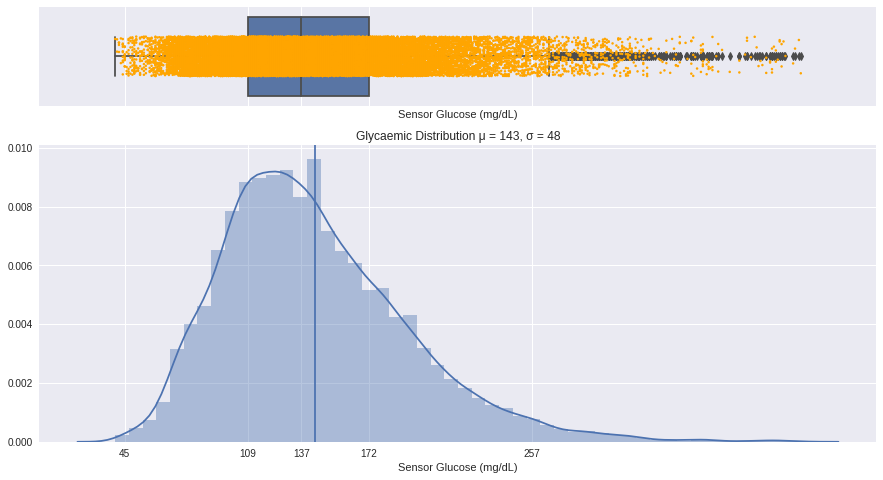

In [9]:
dist_plot(data["Sensor Glucose (mg/dL)"])

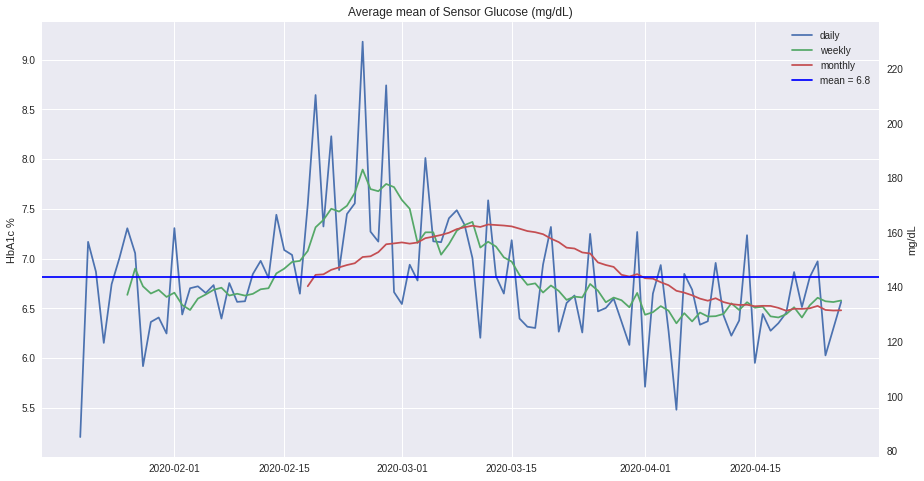

In [54]:
comparative_hba1c_plot(data, kind="mean")

In [61]:
proportion: Callable = lambda frame: 100 * frame[ (frame >= 70) & (frame <= 180) ].count() / frame.count()

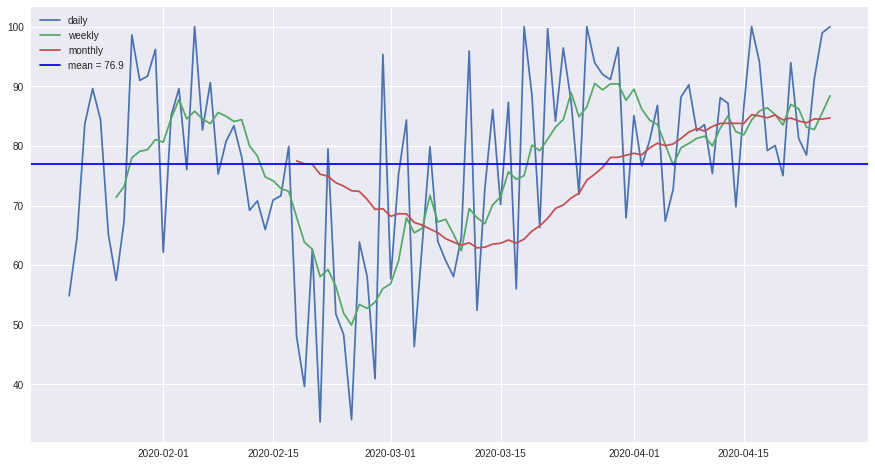

In [76]:
time_in_range(data)

In [62]:
proportions: pd.Series = data["Sensor Glucose (mg/dL)"].groupby(data.index.date).apply(proportion)

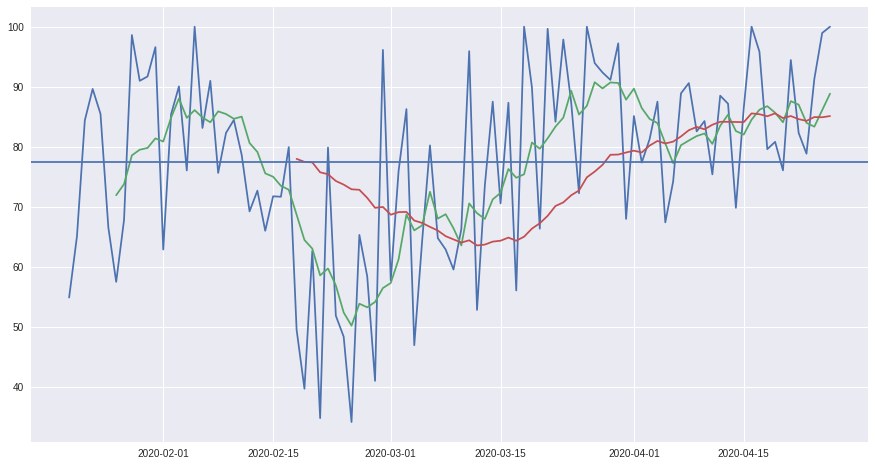

In [64]:
proportions.plot()
proportions.rolling(7).mean().plot()
proportions.rolling(30).mean().plot()
plt.axhline(proportions.mean())

In [49]:
for date, frame in data["Sensor Glucose (mg/dL)"].groupby(data.index.date):
    foo = 100 * frame[ (frame >= 70) & (frame <= 180) ].count() / frame.count()
    print(foo)

54.83870967741935
65.04854368932038
84.375
89.61538461538461
85.46099290780141
66.52173913043478
57.45454545454545
67.77251184834124
98.61111111111111
90.97222222222223
91.70124481327801
96.5909090909091
62.84722222222222
85.40925266903915
90.04329004329004
76.02996254681648
100.0
83.11111111111111
90.97222222222223
75.61837455830388
82.29166666666667
84.45229681978799
78.6046511627907
69.2
72.65917602996255
65.97222222222223
71.71314741035856
71.64750957854406
79.91967871485944
49.458483754512635
39.629629629629626
62.59842519685039
34.73684210526316
79.85074626865672
51.80722891566265
48.31460674157304
34.07821229050279
65.27777777777777
58.39160839160839
40.94488188976378
96.12403100775194
57.69230769230769
75.9375
86.25954198473282
46.89265536723164
64.23611111111111
80.20833333333333
64.75095785440612
62.84722222222222
59.50704225352113
66.26506024096386
95.91078066914498
52.77777777777778
73.59154929577464
87.5
70.52631578947368
87.32394366197182
56.02094240837696
100.0
89.860139

In [55]:
type(data["Sensor Glucose (mg/dL)"].groupby(data.index.day).median())

pandas.core.series.Series

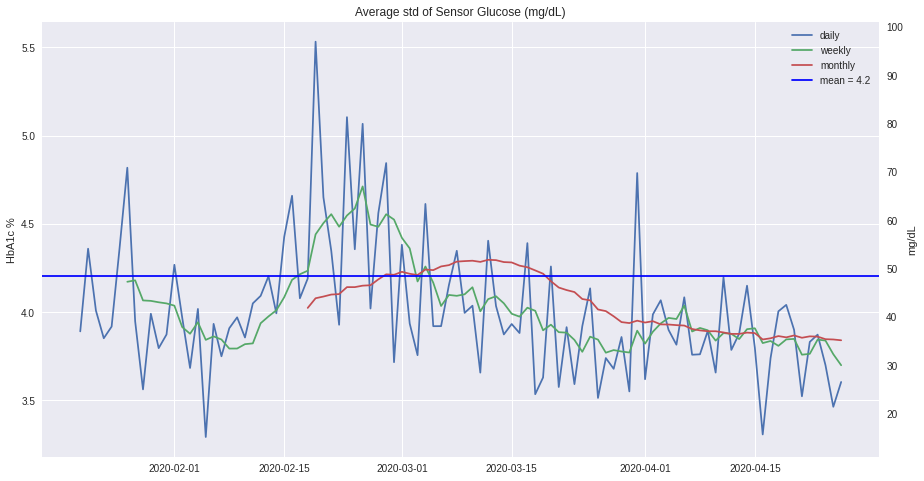

In [9]:
comparative_hba1c_plot(data, kind='std')

In [61]:
month = data.loc["2020-03-01":"2020-04-26", :]
latest = data.loc["2020-04-22":"2020-04-26", :]

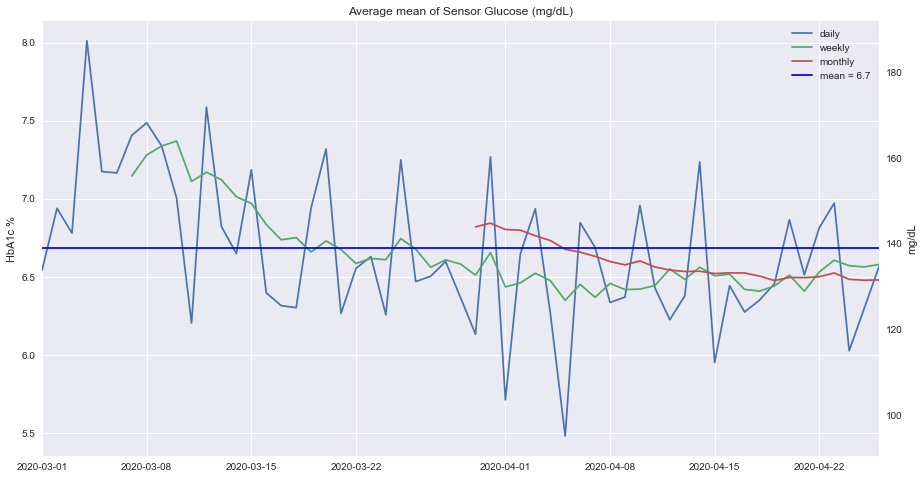

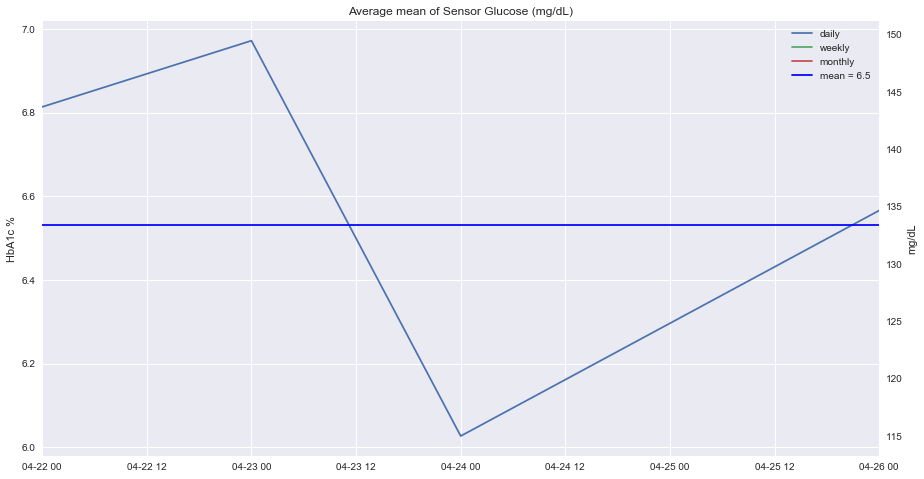

In [64]:
comparative_hba1c_plot(month)
plt.figure()
comparative_hba1c_plot(latest)

In [54]:
# maybe we should interpolate grouping by day ?

In [55]:
#latest.loc["2020-04-15", "Sensor Glucose (mg/dL)"].interpolate().plot()
#latest.loc["2020-04-15", "Sensor Glucose (mg/dL)"].plot()

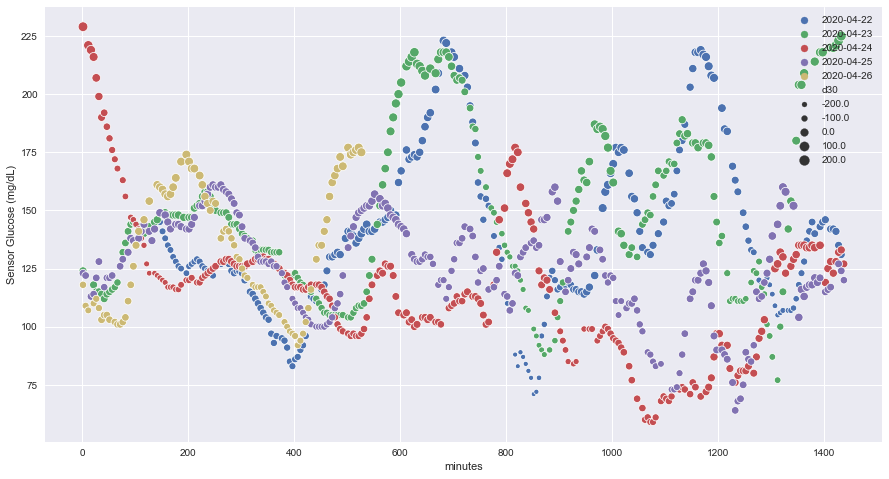

In [56]:
sns.scatterplot(
    data=latest,
    x="minutes",
    y="Sensor Glucose (mg/dL)",
    hue=latest.index.date,
    size="d30"
)

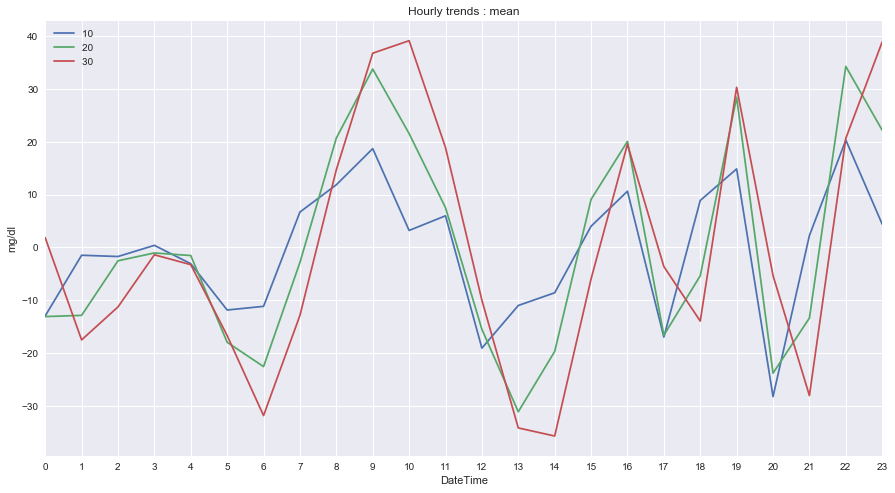

In [57]:
hourly_trends(latest)

In [16]:
#hourly_trends(basal, kind="std")

In [17]:
basal = basal_only(latest)

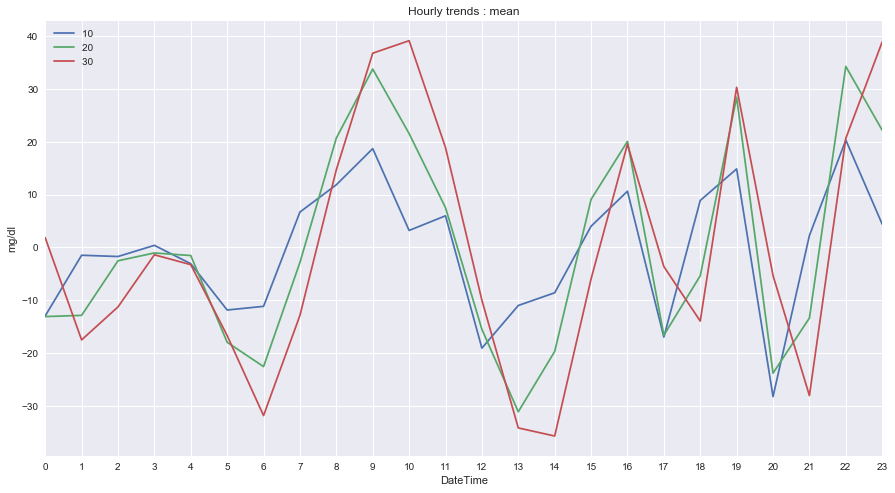

In [18]:
hourly_trends(basal)

In [19]:
#hourly_trends(basal, kind="std")

In [20]:
bar = nonull_indices(latest, "BWZ Carb Input (grams)")

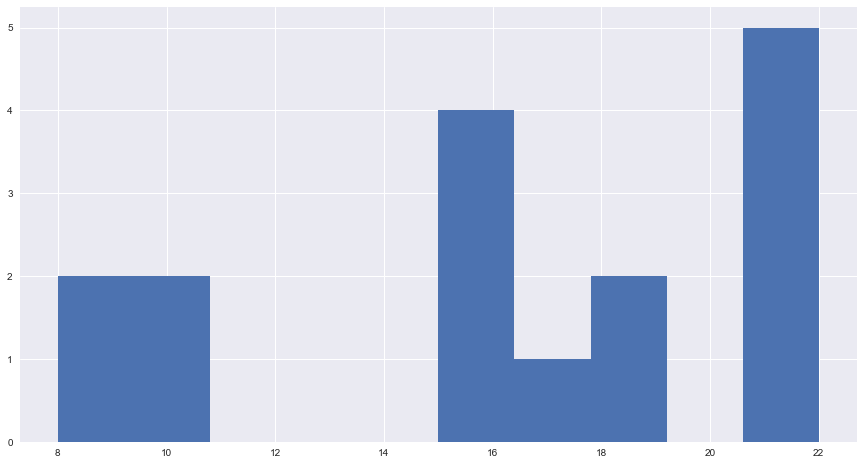

In [21]:
bar.hour.to_series().hist()

In [22]:
foo = nonull_indices(latest, "BWZ Correction Estimate (U)")

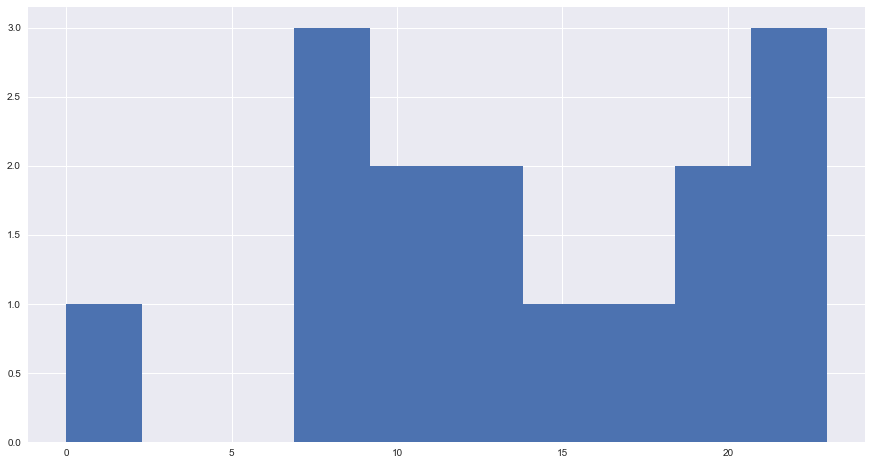

In [23]:
foo.hour.to_series().hist()